## Fairness Analysis of NamSor's Gender API Endpoint using Aequitas

Part I: Fairness of Gender API Endpoint by Gender and Ethnicity

In [1]:
import pandas as pd
import seaborn as sns
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
from aequitas.plotting import Plot
import pdfkit as pdf

# import warnings; warnings.simplefilter('ignore')

%matplotlib inline

In [2]:
df = pd.read_csv("data/compas_gender_predictions.csv")
df.head()

,Unnamed: 0,entity_id,first,last,sex,sex_pred,race,score,label_value
0,0,1,miguel,hernandez,Male,Male,Other,0.000714,1.0
1,1,3,kevon,dixon,Male,Male,African-American,0.043280,1.0
2,2,4,ed,philo,Male,Male,African-American,0.031187,1.0
3,3,5,marcu,brown,Male,Male,African-American,0.377335,1.0
4,4,6,bouthy,pierrelouis,Male,Male,Other,0.490869,1.0


In [3]:
# Non String columns will lead to problems later so we have to find out if there are any
non_attr_cols = ['id', 'model_id', 'entity_id', 'score', 'label_value', 'rank_abs', 'rank_pct']
attr_cols = df.columns[~df.columns.isin(non_attr_cols)]  # index of the columns that are
df.columns[(df.dtypes != object) & (df.dtypes != str) & (df.columns.isin(attr_cols))]

Index(['Unnamed: 0'], dtype='object')

In [4]:
# And delete them.
df = df.drop(['Unnamed: 0'], axis=1)
df.head()

,entity_id,first,last,sex,sex_pred,race,score,label_value
0,1,miguel,hernandez,Male,Male,Other,0.000714,1.0
1,3,kevon,dixon,Male,Male,African-American,0.043280,1.0
2,4,ed,philo,Male,Male,African-American,0.031187,1.0
3,5,marcu,brown,Male,Male,African-American,0.377335,1.0
4,6,bouthy,pierrelouis,Male,Male,Other,0.490869,1.0


In [5]:
# we only want to look at gender here, since that is what we calculated label_value for
df = df.drop(['sex_pred', 'first', 'last'], axis=1) # if we don't drop the tables, Aequitas thinks these are attributes by which groups should be separated

In [6]:
# now we remove groups that are too small
df = df[df.race.isin(['African-American', 'Caucasian', 'Hispanic'])]

In [7]:
df.shape

(6787, 5)

In [8]:
df["combined_attribute"] = df["sex"] + " " + df["race"]

In [9]:
df.head()

,entity_id,sex,race,score,label_value,combined_attribute
1,3,Male,African-American,0.043280,1.0,Male African-American
2,4,Male,African-American,0.031187,1.0,Male African-American
3,5,Male,African-American,0.377335,1.0,Male African-American
6,8,Male,Caucasian,0.000248,1.0,Male Caucasian
8,10,Female,Caucasian,0.001108,1.0,Female Caucasian


## Group Metrics
First, let's calculate the group metrics like tp, fn, and so on. For determining which score is considered to be a prediction of the classification being correct we will use a score treshold that is the maximum score, or minimum probabilityCalibrated. We do this, because NamSor does make a prediction starting at that score and we want to look at the raw prediction first. We will look at different scores later on to see which score produces which fairness.

In [10]:
t = df[["score"]].max()[0]
g = Group()
xtab, _ = g.get_crosstabs(df, attr_cols=["sex", "race", "combined_attribute"], score_thresholds= {'score': [t]})
absolute_metrics = g.list_absolute_metrics(xtab)

model_id, score_thresholds 0 {'score': [0.4970725596550762]}


In [11]:
df[["score"]].max()[0]


0.4970725596550762

In [12]:
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,0,0.4970725596550762_ore,6787,sex,Female,1322,0,99,0,0,1223,1223,99,1322,6787
1,0,0.4970725596550762_ore,6787,sex,Male,5465,0,310,0,0,5155,5155,310,5465,6787
2,0,0.4970725596550762_ore,6787,race,African-American,3696,0,292,0,0,3404,3404,292,3696,6787
3,0,0.4970725596550762_ore,6787,race,Caucasian,2454,0,100,0,0,2354,2354,100,2454,6787
4,0,0.4970725596550762_ore,6787,race,Hispanic,637,0,17,0,0,620,620,17,637,6787
5,0,0.4970725596550762_ore,6787,combined_attribute,Female African-American,652,0,64,0,0,588,588,64,652,6787
6,0,0.4970725596550762_ore,6787,combined_attribute,Female Caucasian,567,0,34,0,0,533,533,34,567,6787
7,0,0.4970725596550762_ore,6787,combined_attribute,Female Hispanic,103,0,1,0,0,102,102,1,103,6787
8,0,0.4970725596550762_ore,6787,combined_attribute,Male African-American,3044,0,228,0,0,2816,2816,228,3044,6787
9,0,0.4970725596550762_ore,6787,combined_attribute,Male Caucasian,1887,0,66,0,0,1821,1821,66,1887,6787


In [13]:
def _color_red_or_green_or_orange(val): # https://stackoverflow.com/questions/28075699/coloring-cells-in-pandas
    try:
        if(val > 0.8 and val < 1.2):
            color = 'green'
        elif(val < 0.8):
            color = 'orange'
        else: color = 'red'
        return 'color: %s' % color
    except:
        return 'color: black'



In [14]:
xtab[['attribute_name', 'attribute_value'] + absolute_metrics]

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,sex,Female,1.0,0.0,NaN,0.074887,1.0,0.0,NaN,0.925113,0.194784,1.0,0.925113
1,sex,Male,1.0,0.0,NaN,0.056725,1.0,0.0,NaN,0.943275,0.805216,1.0,0.943275
2,race,African-American,1.0,0.0,NaN,0.079004,1.0,0.0,NaN,0.920996,0.544571,1.0,0.920996
3,race,Caucasian,1.0,0.0,NaN,0.040750,1.0,0.0,NaN,0.959250,0.361574,1.0,0.959250
4,race,Hispanic,1.0,0.0,NaN,0.026688,1.0,0.0,NaN,0.973312,0.093856,1.0,0.973312
5,combined_attribute,Female African-American,1.0,0.0,NaN,0.098160,1.0,0.0,NaN,0.901840,0.096066,1.0,0.901840
6,combined_attribute,Female Caucasian,1.0,0.0,NaN,0.059965,1.0,0.0,NaN,0.940035,0.083542,1.0,0.940035
7,combined_attribute,Female Hispanic,1.0,0.0,NaN,0.009709,1.0,0.0,NaN,0.990291,0.015176,1.0,0.990291
8,combined_attribute,Male African-American,1.0,0.0,NaN,0.074901,1.0,0.0,NaN,0.925099,0.448504,1.0,0.925099
9,combined_attribute,Male Caucasian,1.0,0.0,NaN,0.034976,1.0,0.0,NaN,0.965024,0.278032,1.0,0.965024


## Disparities of Group Metrics

In [15]:
#aq_palette = sns.diverging_palette(240, 10, n=9) #sns.diverging_palette(225, 35, n=2)
b = Bias()

In [16]:
bdf = b.get_disparity_predefined_groups(xtab, original_df=df, 
                                        ref_groups_dict={'sex':'Male', 'race':'Caucasian', 'combined_attribute':'Male Caucasian'})

bdf_overview = bdf[["attribute_name", "attribute_value", "precision_disparity", "fdr_disparity"]]

bdf_overview.style.applymap(_color_red_or_green_or_orange)

get_disparity_predefined_group()


,attribute_name,attribute_value,precision_disparity,fdr_disparity
0,sex,Female,0.980746,1.32018
1,sex,Male,1,1
2,race,African-American,0.96012,1.93877
3,race,Caucasian,1,1
4,race,Hispanic,1.01466,0.654914
5,combined_attribute,Female African-American,0.934527,2.80647
6,combined_attribute,Female Caucasian,0.974106,1.71445
7,combined_attribute,Female Hispanic,1.02618,0.277582
8,combined_attribute,Male African-American,0.958628,2.1415
9,combined_attribute,Male Caucasian,1,1


## Fairness Metrics

In [17]:
f = Fairness()
fdf = f.get_group_value_fairness(bdf)

In [18]:
def _color_red_or_green(val): # https://stackoverflow.com/questions/28075699/coloring-cells-in-pandas
    color = 'green' if val else 'red'
    return 'color: %s' % color

In [19]:
fdf[["attribute_name", "attribute_value", "Impact Parity", "Precision Parity", "FDR Parity", "FPR Parity", "TPR Parity", "Equalized Odds", "TypeI Parity"]].style.applymap(_color_red_or_green)

,attribute_name,attribute_value,Impact Parity,Precision Parity,FDR Parity,FPR Parity,TPR Parity,Equalized Odds,TypeI Parity
0,sex,Female,True,True,False,True,True,True,False
1,sex,Male,True,True,True,True,True,True,True
2,race,African-American,True,True,False,True,True,True,False
3,race,Caucasian,True,True,True,True,True,True,True
4,race,Hispanic,True,True,False,True,True,True,False
5,combined_attribute,Female African-American,True,True,False,True,True,True,False
6,combined_attribute,Female Caucasian,True,True,False,True,True,True,False
7,combined_attribute,Female Hispanic,True,True,False,True,True,True,False
8,combined_attribute,Male African-American,True,True,False,True,True,True,False
9,combined_attribute,Male Caucasian,True,True,True,True,True,True,True


In [20]:
gaf = f.get_group_attribute_fairness(fdf.fillna(True))
gaf[["attribute_name", "Impact Parity", "Precision Parity", "FDR Parity", "FPR Parity", "TPR Parity", "Equalized Odds", "TypeI Parity"]].style.applymap(_color_red_or_green)

,attribute_name,Impact Parity,Precision Parity,FDR Parity,FPR Parity,TPR Parity,Equalized Odds,TypeI Parity
0,combined_attribute,True,True,False,True,True,True,False
1,race,True,True,False,True,True,True,False
2,sex,True,True,False,True,True,True,False


In [21]:
gof = f.get_overall_fairness(fdf)
gof

{'Unsupervised Fairness': False,
 'Supervised Fairness': False,
 'Overall Fairness': False}

In [32]:
xtab[['attribute_value'] + absolute_metrics].round(2).to_latex('graphics/group_metrics_maxthreshold_gender.tex')
fdf[["attribute_value", "ppr_disparity", "pprev_disparity", "precision_disparity", "fdr_disparity", "fpr_disparity", "tpr_disparity"]].round(2).to_latex('graphics/disparities_maxthreshold_gender.tex')
fdf[["attribute_value", "Impact Parity", "Precision Parity", "FPR Parity", "TPR Parity", "Equalized Odds", "TypeI Parity", "Unsupervised Fairness"]].to_latex('graphics/fairness_maxthreshold_gender.tex')
gaf.to_latex('graphics/overall_fairness_maxthreshold_gender.tex')

### Analysis
We find that:
* PPREV or **Impact Parity**
* TPR- or Recall Parity or **Equal Opportunity**
* PPV- or Precision- or **Predictive Parity** (the colors are confusing here - if there is PPV Parity there has to be FDR Parity also)
* **Equalized Odds** (TPR and FPR) 
* **Predictive Equality** (FPR) 
* **Equal Opportunity** (TPR) 
* Because of Equal Opportunity and limited Predictive Equality there is also **Overall Accuracy Equality**
* Because of PPV/Predictive Parity and limited FPR/Predictive Equality Parity there is also **Type I**

There is no
* PPR- or Demographic- or **Statistical Parity**
* Because of Impact Parity but no Statistical Parity, there is no **Unsupervised Fairness**.

These are actually Fairness measures on the data set, which can not be given if the data set is not representational of all groups!

Not measured:
* FOR Parity
* Type II Parity (FNR/Equal Opportunity and FOR Parity)
* Supervised Fairness (Type I and II Parity)

## Impact of Treshold chosen
Now we will check whether chosing different tresholds results in different fairness.

In [23]:
from numpy import arange

disparities_res = pd.DataFrame({'model_id' : []})
fairness_res = pd.DataFrame({'model_id' : []})
overall_fairness_res = pd.DataFrame({'model_id' : []})
all_tables = []
complete_tables = []

g = Group()

tresholds = arange(0.1, 0.5, 0.1)
for t in tresholds:
    xtab, _ = g.get_crosstabs(df, 
                              attr_cols=["combined_attribute"], 
                              score_thresholds= {'score': [t]})
    absolute_metrics = g.list_absolute_metrics(xtab)
    
    b = Bias()
    bdf = b.get_disparity_predefined_groups(xtab, original_df=df, 
                                            ref_groups_dict={'combined_attribute':'Male Caucasian'}, 
                                            input_group_metrics=["ppr", "tpr", "fpr", "precision", "tnr", "npv", "pprev", "for", "fdr", "fnr"],
                                            check_significance=False, 
                                            mask_significance=False)
    
    f = Fairness()
    fdf = f.get_group_value_fairness(bdf)
    gaf = f.get_group_attribute_fairness(fdf)
    
    # save results
    fdf['model_id'] = t.round(2)
    fairness_by_group = fdf[['model_id', 'attribute_value'] + f.list_parities(fdf)]
    fairness_res = fairness_res.append(fairness_by_group, sort=False)
    
    gaf['model_id'] = t.round(2)
    overall_fairness_res = overall_fairness_res.append(gaf, sort=False)
    
    bdf['model_id'] = t.round(2)
    disparities_res = disparities_res.append(bdf, sort=False)
    complete_tables.append(bdf)

model_id, score_thresholds 0 {'score': [0.1]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'score': [0.2]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'score': [0.30000000000000004]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'score': [0.4]}
get_disparity_predefined_group()


In [24]:
disparity_overview = disparities_res[["model_id", "attribute_value", "ppr_disparity", "tpr_disparity", "fpr_disparity", "precision_disparity", "tnr_disparity", "npv_disparity", "pprev_disparity", "for_disparity", "fdr_disparity", "fnr_disparity"]].groupby(["model_id", "attribute_value"]).mean()

In [25]:
disparity_overview.style.applymap(_color_red_or_green_or_orange)

In [26]:
fairness_overview = fairness_res[["model_id", "attribute_value"] + f.list_parities(fdf)].groupby(["model_id", "attribute_value"]).max()

In [27]:
fairness_overview.style.applymap(_color_red_or_green)

In [28]:
overall_fairness_res

,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0.1,0.1_ore,combined_attribute,False,True,False,False,True,False,True,False,False,True,False,False,False,False,False
0,0.2,0.2_ore,combined_attribute,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False
0,0.3,0.30000000000000004_ore,combined_attribute,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False
0,0.4,0.4_ore,combined_attribute,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False


We find that:

* PPREV or Impact Parity
* TPR- or Recall Parity or Equal Opportunity
* PPV- or Precision- or Predictive Parity (the colors are confusing here - if there is PPV Parity there has to be FDR Parity also)
* Equal Opportunity (TPR)
* Because of PPV/Predictive Parity and limited FPR/Predictive Equality there is also Type I
* FOR Parity only for 0.1

There is no
* Equalized Odds (TPR and FPR) because there is not
* Predictive Equality (FPR) for Hispanics of any gender (0.4) and no FPRE for any except Caucasians  (<0.4) However, all groups over all scores except Hispanic women have "better" that is lower FPRs than Caucasian men, which is actually good. 
* Because of Equal Opportunity and no Predictive Equality there is also no Overall Accuracy Equality
* PPR- or Demographic- or Statistical Parity
* Because of Impact Parity but no Statistical Parity, there is no Unsupervised Fairness. -> These are actually Fairness measures on the data set, which can not be given if the data set is not representational of all groups!
* Type II Parity (FNR/Equal Opportunity and FOR Parity)
* Supervised Fairness (Type I and II Parity)

**We can conclude that in this example, not setting a threshold yields the fairest results**

In [29]:
disparity_overview.to_html('graphics/disparities_by_threshold_gender.html')
fairness_overview.to_html('graphics/fairness_by_threshold_gender.html')
overall_fairness_res.to_html('graphics/overall_fairness_by_threshold_gender.html')

In [30]:
disparity_overview.to_latex('graphics/disparities_by_threshold_gender.tex')
fairness_overview.to_latex('graphics/fairness_by_threshold_gender.tex')
overall_fairness_res.to_latex('graphics/overall_fairness_by_threshold_gender.tex')

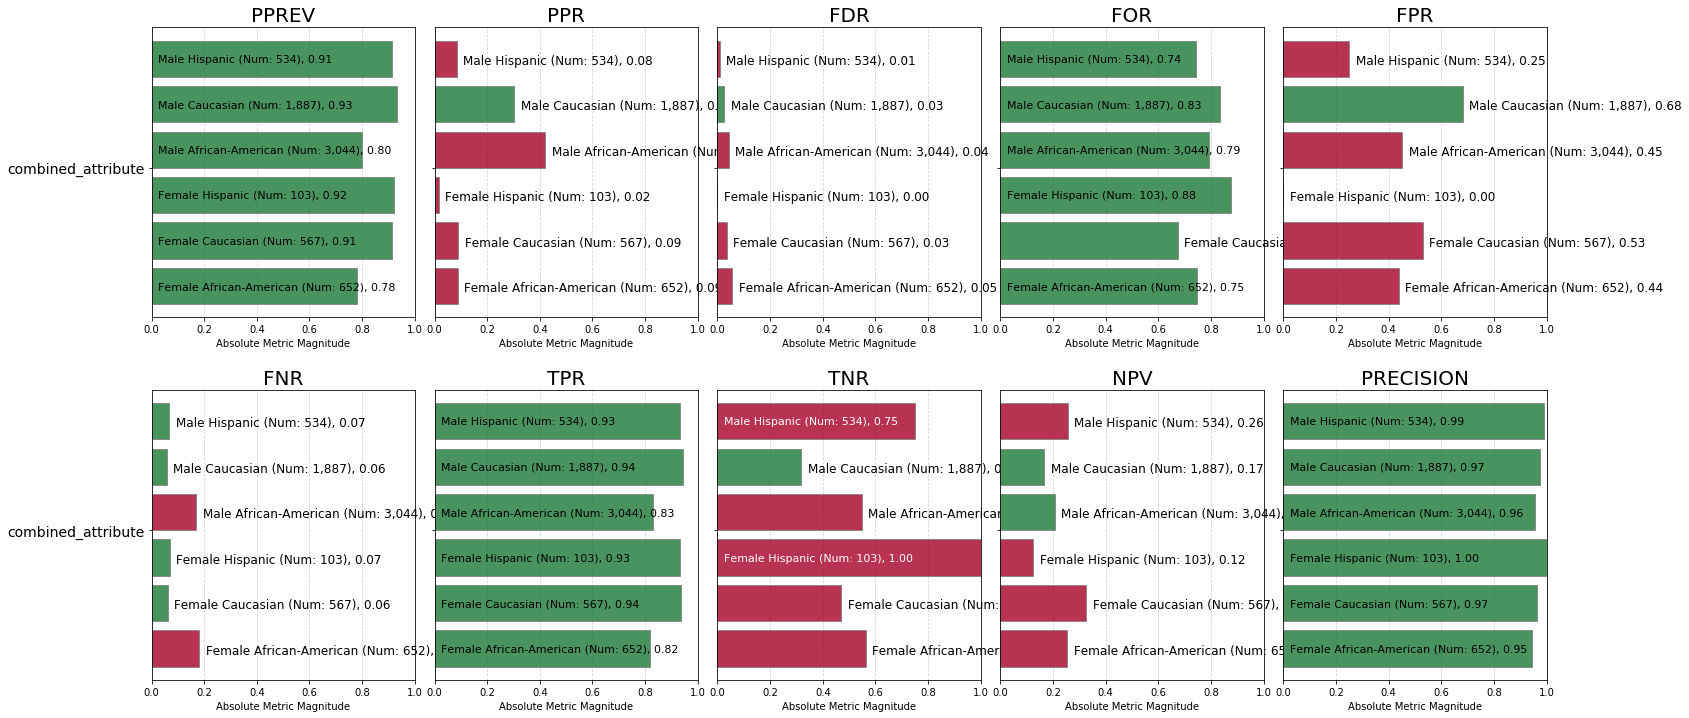

<Figure size 432x288 with 0 Axes>

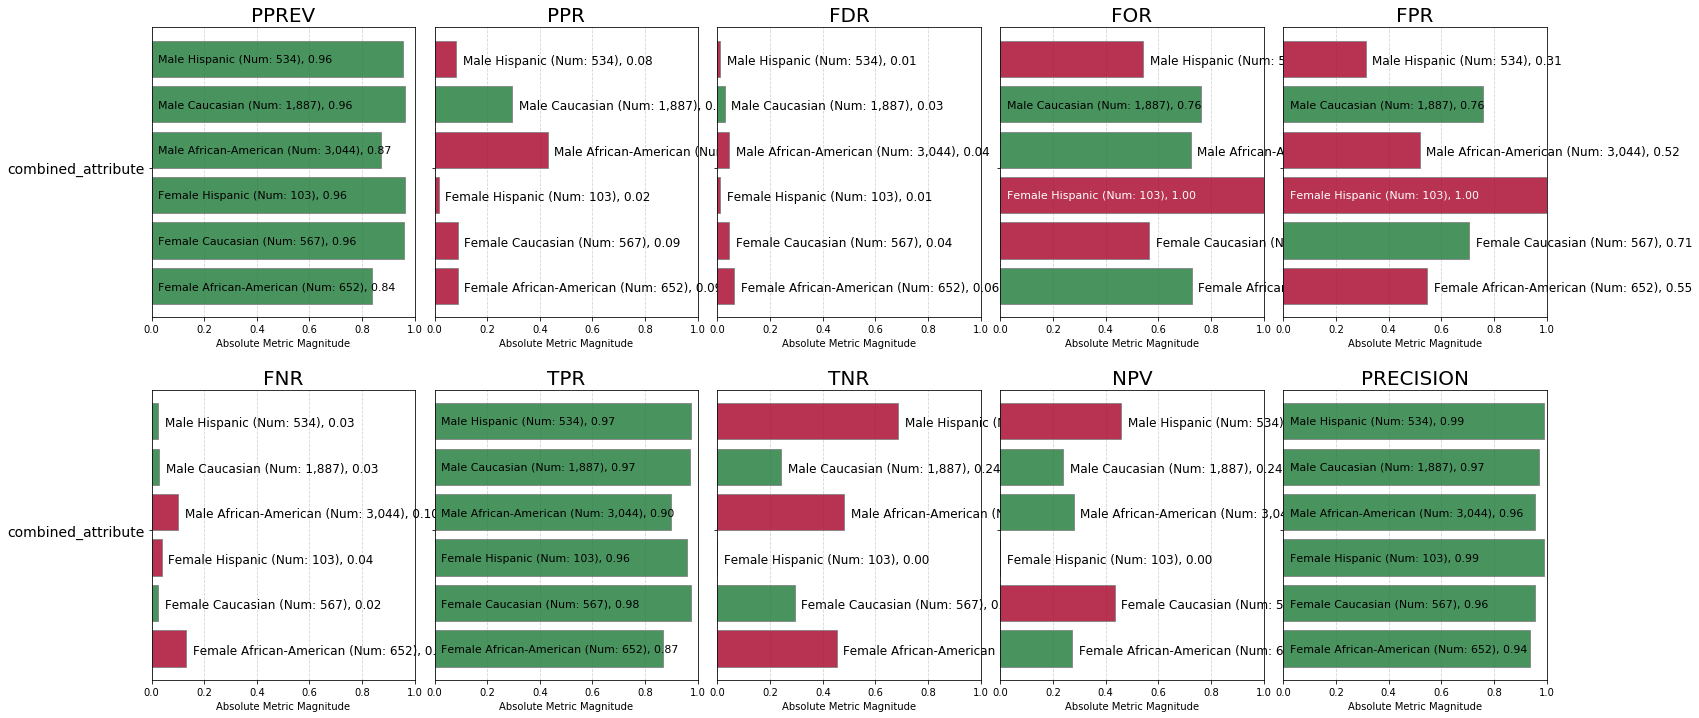

<Figure size 432x288 with 0 Axes>

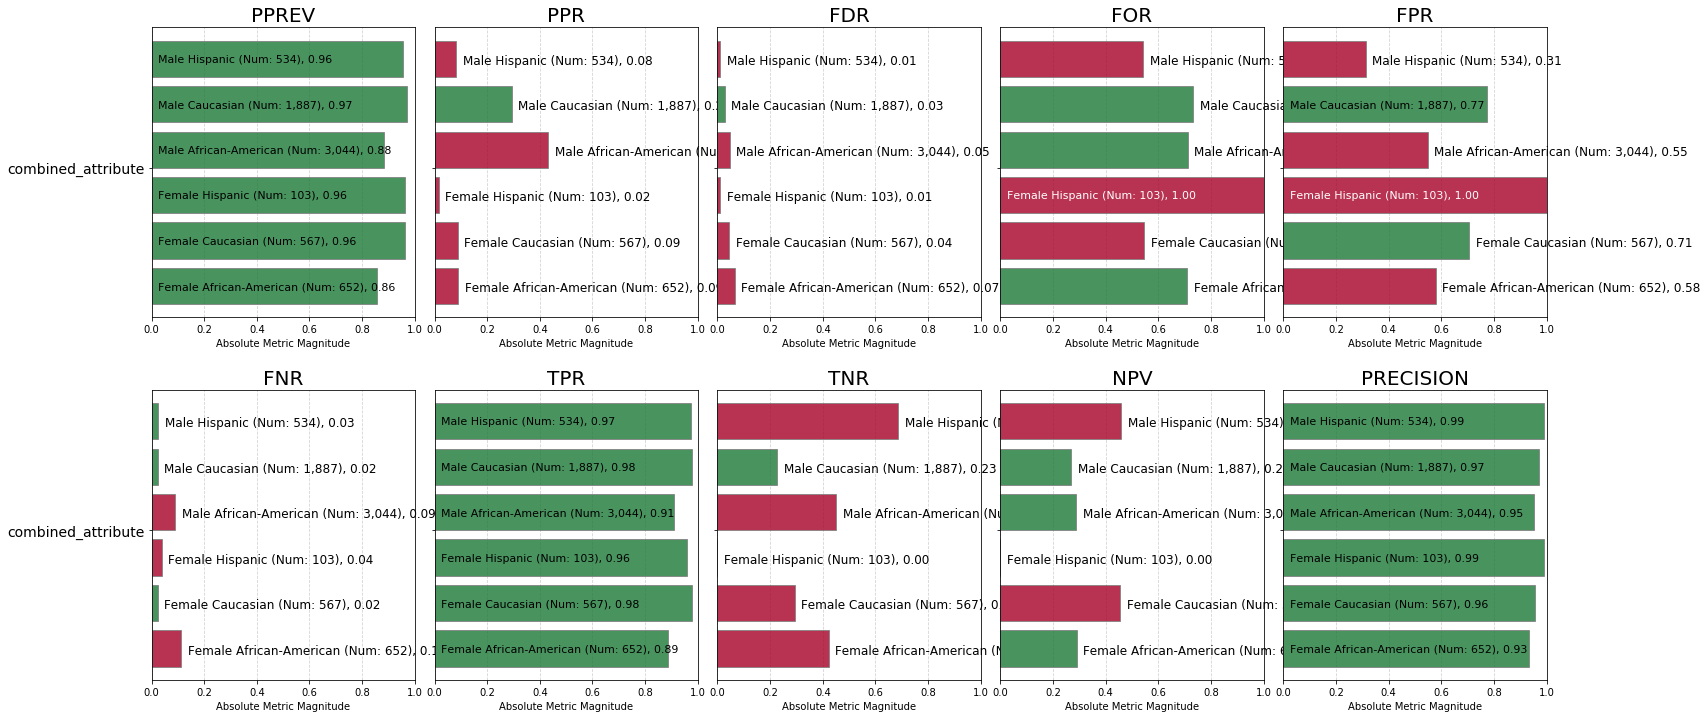

<Figure size 432x288 with 0 Axes>

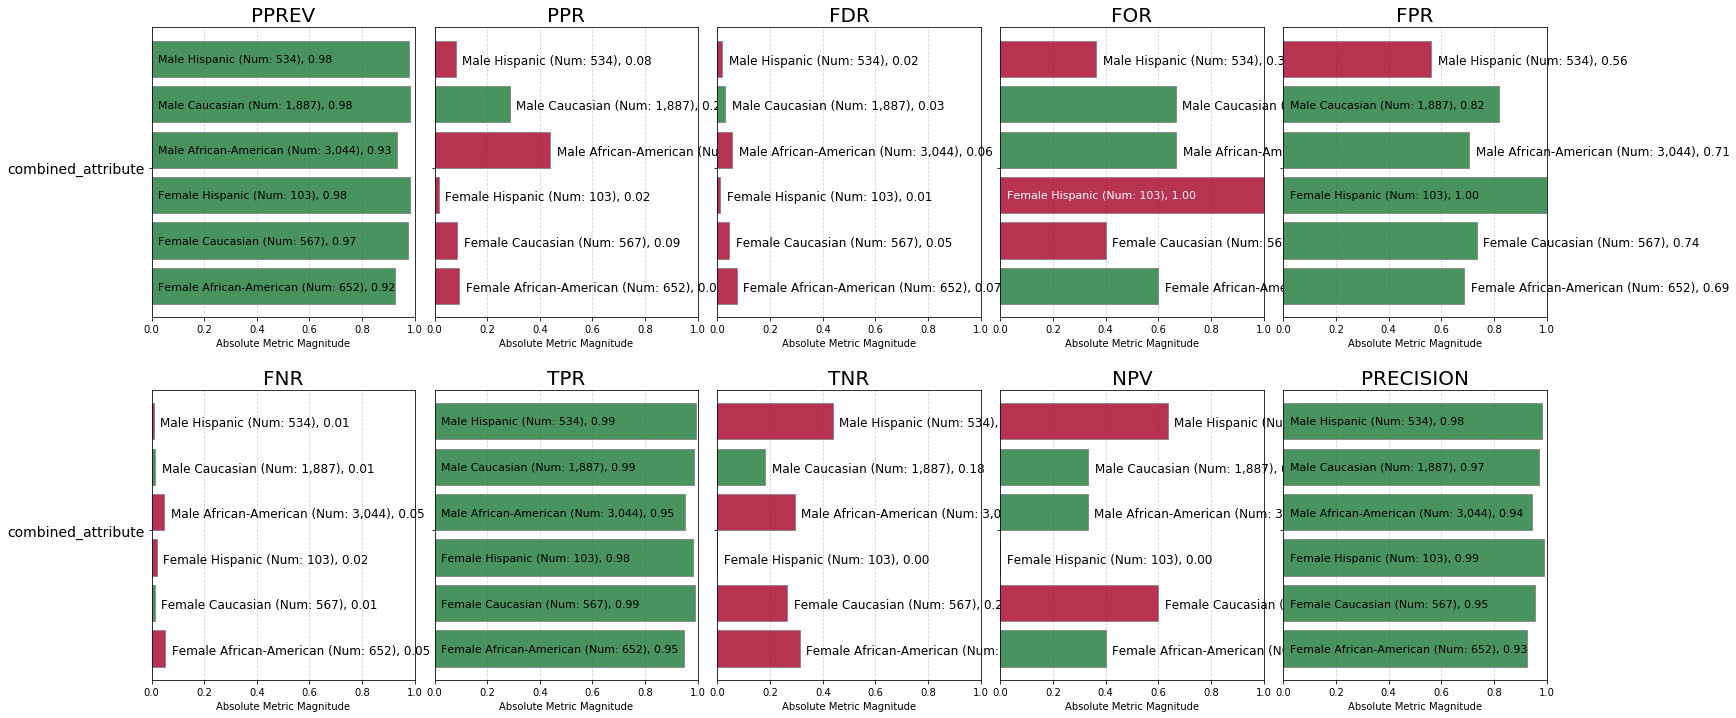

<Figure size 432x288 with 0 Axes>

In [31]:
aqp = Plot()
i = 0.1
for table in complete_tables:
    fdf = f.get_group_value_fairness(table)
    plot = aqp.plot_fairness_group_all(fdf, ncols=5, metrics = "all")
    plot.savefig('graphics/gender_endpoint_disparities_{}.pdf'.format(i), format='pdf')
    i = i + 0.1